In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tenpy.algorithms.tebd import RandomUnitaryEvolution
from tenpy.networks.mps import MPS
from tenpy.networks.site import SpinHalfSite

Given a normalized state $|\psi\rangle = \sum_{x=1}^N c_x \, |x\rangle,$ 
the inverse participation ratio (IPR) is $\sum_{x=1}^N |c_x|^4$  

Introduce two replicas of the Hilbert space:  

$$
|\psi\rangle^{\otimes 2} = \sum_{x,y} c_x c_y \, |x\rangle \otimes |y\rangle.
$$  

Define the diagonal projector:  

$$
\mathcal{P} = \sum_{x=1}^N |x\rangle \langle x| \otimes |x\rangle \langle x|.
$$  

Then the IPR can be written as  

$$
\mathrm{IPR} = \langle \psi|^{\otimes 2} \, \mathcal{P} \, |\psi\rangle^{\otimes 2} = 
\sum_{x=1}^N 
\big( \langle \psi| \otimes \langle \psi| \big)
\Big( |x\rangle \otimes |x\rangle \Big)
\Big( \langle x| \otimes \langle x| \Big)
\big( |\psi\rangle \otimes |\psi\rangle \big)
= \sum_{x,y} c_x^{*} c_y^{*} \, c_x c_y \; \delta_{xy}.
$$  


In [ ]:
# compute IPR
def ipr2(psi: MPS) -> float:
    """Compute IPR = sum_x |psi_x|^4 using two-replica transfer contraction.
       Cost scales like sum_i chi_i^6 (not good)"""
    psi.canonical_form()  # left orthognalized for numerical stability
    env = np.array([[1.0 + 0.0j]])  # (1x1) left environment
    for i in range(psi.L): # loop over all qubit sites
        B = psi.get_B(i, form='B').to_ndarray()  # extract site tensor of shape (chiL, d, chiR)
        chiL, d, chiR = B.shape
        env_mat = env.reshape(chiL * chiL, chiL * chiL) # reshape into chi^2 matrix for 2-replica trick
        env_next = np.zeros((chiR * chiR, chiR * chiR), dtype=complex) # initialize next env to right

        for s in range(d): # loop over local basis state s
            As = B[:, s, :]  # extract site for state s                   
            K  = np.kron(As, As) # build A_s tensor product with itself (2 replicas of As)            
            env_next += K.conj().T @ env_mat @ K # update environment with the 2-replica transfer operator

        env = env_next
    return float(np.real(env.squeeze())) # this is the IPR

Layer 01: disc weight per step=0.0, cumulutative disc weight=0.0, max_chi=4, S_mid=1.0603
Layer 02: disc weight per step=0.0, cumulutative disc weight=0.0, max_chi=16, S_mid=1.3310
Layer 03: disc weight per step=0.0011303642483190643, cumulutative disc weight=0.0011303642483190643, max_chi=24, S_mid=1.5761
Layer 04: disc weight per step=0.03212979164746291, cumulutative disc weight=0.03326015589578197, max_chi=24, S_mid=2.3152
Layer 05: disc weight per step=0.1714157725423575, cumulutative disc weight=0.20467592843813945, max_chi=24, S_mid=2.4365
Layer 06: disc weight per step=0.34522447514229493, cumulutative disc weight=0.5499004035804343, max_chi=24, S_mid=2.6329
Layer 07: disc weight per step=0.44896952936956996, cumulutative disc weight=0.9988699329500044, max_chi=24, S_mid=2.6886
Layer 08: disc weight per step=0.5990892307300568, cumulutative disc weight=1.5979591636800612, max_chi=24, S_mid=2.7066
Layer 09: disc weight per step=0.6483071527627007, cumulutative disc weight=2.2462

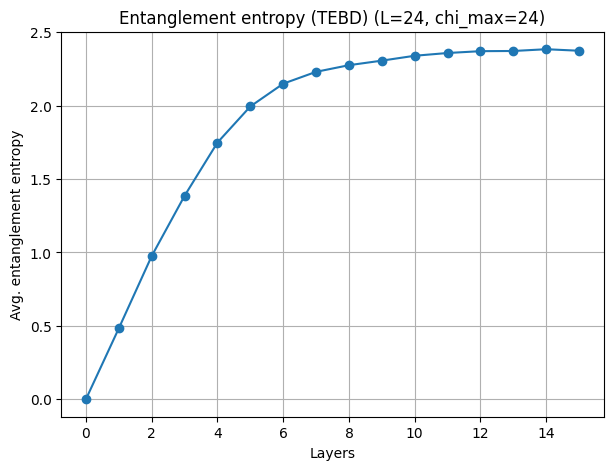

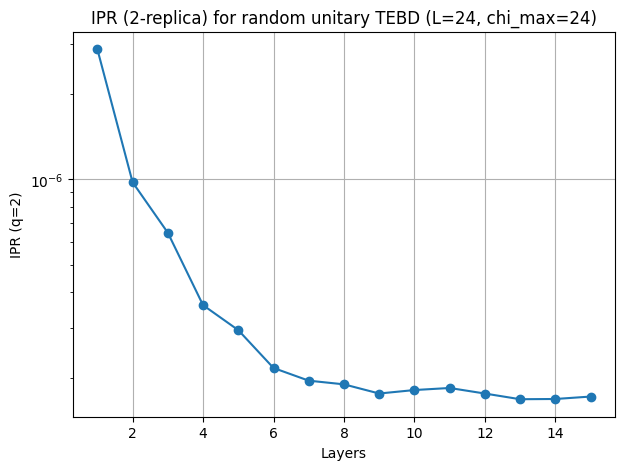

In [ ]:

# parameters
L = 24
D = 15
chi_max = 24 # maximum bond dimension (limits how much entanglement allowed)
svd_min = 1e-4 # minimum value to use from singular value decomp

sites = [SpinHalfSite(conserve=None) for _ in range(L)] # builds Hilbert space
psi = MPS.from_product_state(sites, ["up"] * L, bc="finite") # initalize L qubits in |0> (spin up)

 # tenpy built-in random brickwork evolution
eng = RandomUnitaryEvolution( 
    psi,
    {"trunc_params": {"chi_max": chi_max, "svd_min": svd_min}}
)

# entropy and IPR
S = [float(np.mean(psi.entanglement_entropy()))]
IPR2 = [ipr2(psi)]

# truncation/error
disc_step = []   #dicarded weight per step
disc_weight  = []   #total discarded weight
maxchis   = []   #max chi per step (this saturates quickly)
S_mid     = []   #entanglement entropy across middle cut

for layer in range(D):
    err = eng.evolve(1, dt=1.0)   # one brickwork layer
    psi.canonical_form()

    # collect entropy and IPR
    S.append(float(np.mean(psi.entanglement_entropy())))
    IPR2.append(ipr2(psi))

    # collect error metrics
    disc_step.append(getattr(err, "eps", None))              
    disc_weight.append(getattr(eng.trunc_err, "eps", None))     
    maxchis.append(max(psi.chi))
    S_mid.append(float(psi.entanglement_entropy()[L // 2 - 1]))

    # print all error info
    print(
        f"Layer {layer+1:02d}: "
        f"disc weight per step={disc_step[-1]}, "
        f"cumulutative disc weight={disc_weight[-1]}, "
        f"max_chi={maxchis[-1]}, "
        f"S_mid={S_mid[-1]:.4f}"
    )

# plots
steps = range(D + 1)

plt.figure(figsize=(7,5))
plt.plot(steps, S, marker="o")
plt.xlabel("Layers")
plt.ylabel("Avg. entanglement entropy")
plt.grid(True)
plt.title(f"Entanglement entropy (TEBD) (L={L}, chi_max={chi_max})")
plt.show()

plt.figure(figsize=(7,5))
plt.yscale("log")
plt.plot(range(1, D + 1), IPR2[1:], marker="o")
plt.xlabel("Layers")
plt.ylabel("IPR (q=2)")
plt.grid(True)
plt.title(f"IPR (2-replica) for random unitary TEBD (L={L}, chi_max={chi_max})")
plt.show()


In [19]:
# after the TEBD evolution loop
min_ipr = min(IPR2)
print(f"Minimum IPR reached: {min_ipr:.6g}")
N = 2 ** L # Hilbert space dimension
haar_avg_ipr = 2 / (N + 1)
print(f"Haar average IPR for L={L}: {haar_avg_ipr:.6g}")

Minimum IPR reached: 1.67955e-07
Haar average IPR for L=24: 1.19209e-07
